In [2]:
import sys
sys.path.append('/home/jovyan/work')

In [9]:
from src.data_loader import cargar_dataset, tokenize_sentences_by_char, cargar_oraciones_limpias
from collections import Counter
import re
import matplotlib.pyplot as plt

#### **CARGA DE DATOS**

In [3]:
# Cargamos 5 oraciones limpias del dataset WikiText-103
sentences = cargar_oraciones_limpias(split="train", num_oraciones=5)

# Aplicamos tokenización por caracteres
tokenized_sentences_by_char = tokenize_sentences_by_char(sentences)

# Clonamos para aplicar BPE 
bpe_sentences = [sentence[:] for sentence in tokenized_sentences_by_char]

#### **FUNCIONES AUXILIARES PARA BPE**

In [4]:
# Cuenta todos los pares de tokens adyacentes en las oraciones
def obtener_pares(sentences):
    pairs = Counter()
    for sentence in sentences:
        for i in range(len(sentence) - 1):
            pairs[(sentence[i], sentence[i+1])] += 1
    return pairs

# Realiza el merge de un par de tokens en las oraciones
def merge_pairs(sentences, pair_to_merge):
    new_sentences = []
    for sentence in sentences:
        new_sentence = []
        i = 0
        while i < len(sentence):
            if i < len(sentence) - 1 and (sentence[i], sentence[i+1]) == pair_to_merge:
                new_sentence.append(sentence[i] + sentence[i+1])
                i += 2
            else:
                new_sentence.append(sentence[i])
                i += 1
        new_sentences.append(new_sentence)
    return new_sentences

#### **ENTRENAMIENTO BÁSICO DE BPE**

In [5]:
# Número de merges que queremos aplicar
num_merges = 10

# Lista para guardar el tamaño del vocabulario después de cada merge
vocab_sizes = []

for i in range(num_merges):
    # Contamos los pares
    pairs = obtener_pares(bpe_sentences)
    
    if not pairs:
        break  # Si ya no hay pares, terminamos
    
    # Seleccionamos el par más frecuente
    best_pair = pairs.most_common(1)[0][0]
    
    # Realizamos el merge
    bpe_sentences = merge_pairs(bpe_sentences, best_pair)
    
    # Guardamos el tamaño actual del vocabulario
    vocab_actual = set()
    for sentence in bpe_sentences:
        vocab_actual.update(sentence)
    vocab_sizes.append(len(vocab_actual))
    
    print(f"Merge {i+1}: {best_pair}")
    print(f"Tamaño de vocabulario actual: {len(vocab_actual)}\n")

Merge 1: ('e', ' ')
Tamaño de vocabulario actual: 55

Merge 2: ('s', ' ')
Tamaño de vocabulario actual: 56

Merge 3: ('t', 'h')
Tamaño de vocabulario actual: 57

Merge 4: ('n', ' ')
Tamaño de vocabulario actual: 58

Merge 5: ('d', ' ')
Tamaño de vocabulario actual: 59

Merge 6: ('a', 'l')
Tamaño de vocabulario actual: 60

Merge 7: ('th', 'e ')
Tamaño de vocabulario actual: 61

Merge 8: ('r', 'i')
Tamaño de vocabulario actual: 62

Merge 9: ('t', ' ')
Tamaño de vocabulario actual: 63

Merge 10: ('a', ' ')
Tamaño de vocabulario actual: 64



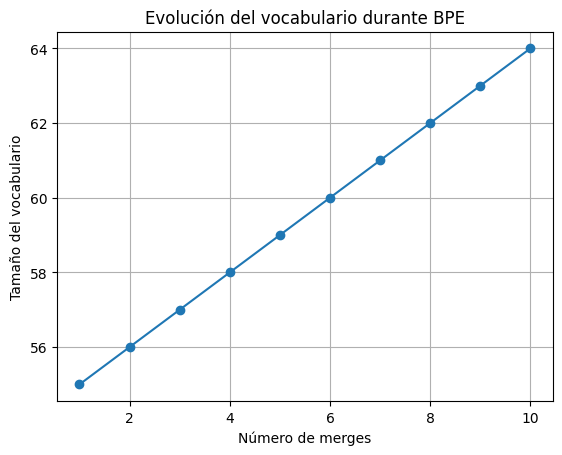

In [6]:
#VISUALIZACIÓN DE LA EVOLUCIÓN DEL VOCABULARIO
plt.plot(range(1, len(vocab_sizes)+1), vocab_sizes, marker='o')
plt.xlabel('Número de merges')
plt.ylabel('Tamaño del vocabulario')
plt.title('Evolución del vocabulario durante BPE')
plt.grid()
plt.show()

#### **EXPERIMENTACIÓN CON BPE**

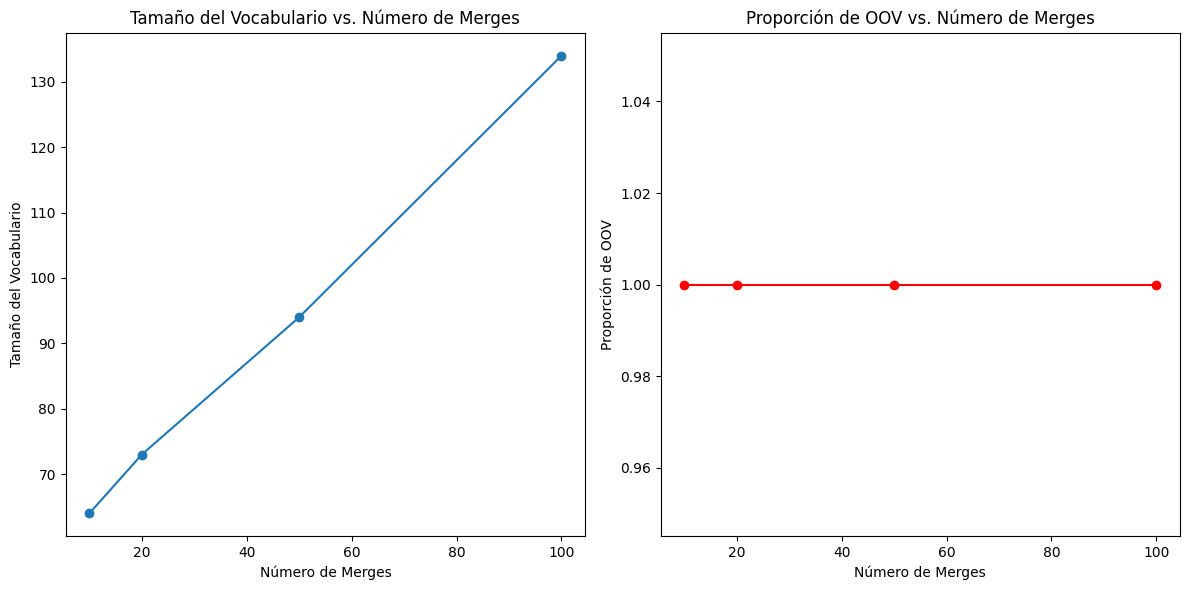

In [7]:
# Lista de diferentes valores para num_merges
num_merges_values = [10, 20, 50, 100]

# Variables para almacenar los resultados
vocab_sizes = []
oov_ratios = []

# Experimentamos con diferentes números de merges
for num_merges in num_merges_values:
    bpe_sentences = [sentence[:] for sentence in tokenized_sentences_by_char]  # Reiniciar las oraciones tokenizadas

    # Entrenamos el modelo BPE
    for merge_step in range(num_merges):
        pairs = obtener_pares(bpe_sentences)
        
        if not pairs:
            break  # Si ya no hay pares, terminamos
        
        # Seleccionamos el par más frecuente
        best_pair = pairs.most_common(1)[0][0]
        
        # Realizamos el merge
        bpe_sentences = merge_pairs(bpe_sentences, best_pair)
        
    # Guardamos el tamaño del vocabulario después de los merges
    vocab_actual = set()
    for sentence in bpe_sentences:
        vocab_actual.update(sentence)
    vocab_sizes.append(len(vocab_actual))
    
    # Evaluamos el número de OOV para algunas palabras
    test_words = ["unhappiness", "computational", "linguistics"]
    oov_count = sum([1 for word in test_words if word not in vocab_actual])
    oov_ratio = oov_count / len(test_words)
    oov_ratios.append(oov_ratio)

# Graficamos los resultados de BPE
plt.figure(figsize=(12, 6))

# Tamaño del vocabulario
plt.subplot(1, 2, 1)
plt.plot(num_merges_values, vocab_sizes, marker='o')
plt.title('Tamaño del Vocabulario vs. Número de Merges')
plt.xlabel('Número de Merges')
plt.ylabel('Tamaño del Vocabulario')

# Proporción de OOV
plt.subplot(1, 2, 2)
plt.plot(num_merges_values, oov_ratios, marker='o', color='r')
plt.title('Proporción de OOV vs. Número de Merges')
plt.xlabel('Número de Merges')
plt.ylabel('Proporción de OOV')

plt.tight_layout()
plt.show()

In [4]:
from src.bpe import BytePairEncoding

In [10]:
# Número de merges que queremos aplicar
num_merges = 10

# Crear una instancia del algoritmo BPE
bpe_model = BytePairEncoding(num_merges)

# Entrenamos el modelo BPE con las oraciones tokenizadas
bpe_model.train(tokenized_sentences_by_char)

# Ver las fusiones realizadas
print("Fusiones realizadas:", bpe_model.merges)

# Mostrar tamaño del vocabulario después de los merges
vocab_size = len(bpe_model.get_vocabulary())
print(f"Tamaño de vocabulario final: {vocab_size}")

Fusiones realizadas: [('e', ' '), ('s', ' '), ('t', 'h'), ('n', ' '), ('d', ' '), ('a', 'l'), ('th', 'e '), ('r', 'i'), ('t', ' '), ('a', ' ')]
Tamaño de vocabulario final: 64


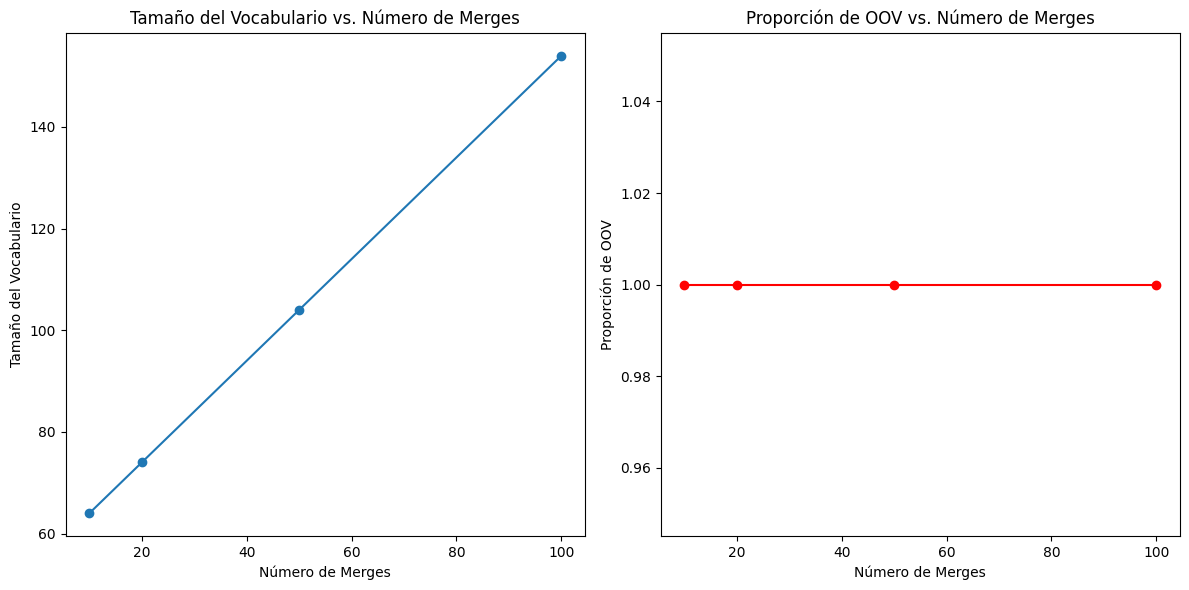

In [18]:
# Ajustamos el número de merges para experimentar con BPE
num_merges_values = [10, 20, 50, 100]  # Diferentes valores de num_merges

# Variables para almacenar los resultados
vocab_sizes = []
oov_ratios = []

# Experimentar con cada valor de num_merges
for num_merges in num_merges_values:
    # Re-iniciar el corpus original (bpe_sentences) para cada experimentación
    bpe_sentences = [sentence[:] for sentence in tokenized_sentences_by_char]
    
    # Entrenamos BPE con el número de merges seleccionado
    bpe_model = BytePairEncoding(num_merges)
    bpe_model.train(bpe_sentences)  # Entrenamiento del modelo BPE
    
    # Calculamos el tamaño del vocabulario final
    vocab_size = len(bpe_model.get_vocabulary())
    vocab_sizes.append(vocab_size)
    
    # Calculamos la proporción de OOV (Out-of-Vocabulary) para un ejemplo de palabra no vista
    test_words = ["unhappiness", "computational", "linguistics"]
    oov_count = sum([1 for word in test_words if word not in bpe_model.get_vocabulary()])
    oov_ratio = oov_count / len(test_words)
    oov_ratios.append(oov_ratio)

# Graficamos los resultados
plt.figure(figsize=(12, 6))

# Tamaño de vocabulario
plt.subplot(1, 2, 1)
plt.plot(num_merges_values, vocab_sizes, marker='o')
plt.title('Tamaño del Vocabulario vs. Número de Merges')
plt.xlabel('Número de Merges')
plt.ylabel('Tamaño del Vocabulario')

# Proporción de OOV
plt.subplot(1, 2, 2)
plt.plot(num_merges_values, oov_ratios, marker='o', color='r')
plt.title('Proporción de OOV vs. Número de Merges')
plt.xlabel('Número de Merges')
plt.ylabel('Proporción de OOV')

plt.tight_layout()
plt.show()

#### **Evaluación del modelo n-grama y cálculo de perplejidad**

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Función para calcular perplejidad
def calculate_perplexity(X_ngram):
    # Sumar los log de las probabilidades para cada token en X_ngram
    log_perplexity = -np.sum(np.log(X_ngram.sum(axis=1)))/X_ngram.shape[0]
    return np.exp(log_perplexity)

# Creamos un modelo n-grama simple (trabajando con caracteres)
def train_ngram_model(corpus, n=3):
    vectorizer = CountVectorizer(ngram_range=(n, n), tokenizer=lambda x: x.split())
    X = vectorizer.fit_transform(corpus)
    return vectorizer, X


In [17]:
# Preparamos los datos tokenizados por caracteres
corpus = [' '.join(sentence) for sentence in tokenized_sentences_by_char]

# Entrenamos el modelo n-grama con n=3 (trigramas)
vectorizer, X_ngram = train_ngram_model(corpus, n=3)

# Calculamos la perplejidad para el modelo n-grama
perplexity_ngram = calculate_perplexity(X_ngram)
print(f"Perplejidad del modelo n-grama: {perplexity_ngram}")

Perplejidad del modelo n-grama: 0.008396794069600123


##### Tokenizaciones con sampling

In [4]:
from src.bpe import BytePairEncoding

In [11]:
# Cargar más oraciones reales
oraciones = cargar_oraciones_limpias(split="train", num_oraciones=100)

# Entrenar BPE con esas oraciones
bpe = BytePairEncoding(num_merges=200)
bpe.train(oraciones)

# Palabra más frecuente que pueda haber en el corpus
word = "happiness"

print("Tokenización determinista:", bpe.tokenize(word))
for i in range(5):
    print(f"Sampling {i+1}:", bpe.tokenize_with_sampling(word, prob=0.5))


Generating test split: 100%|██████| 4358/4358 [00:00<00:00, 39386.53 examples/s]
Generating train split: 100%|█| 1801350/1801350 [00:01<00:00, 934005.14 examples
Generating validation split: 100%|█| 3760/3760 [00:00<00:00, 382716.12 examples/


Tokenización determinista: ['h', 'ap', 'p', 'in', 'es', 's']
Sampling 1: ['h', 'ap', 'p', 'in', 'e', 's', 's']
Sampling 2: ['h', 'ap', 'p', 'i', 'n', 'es', 's']
Sampling 3: ['h', 'a', 'p', 'p', 'i', 'ne', 's', 's']
Sampling 4: ['h', 'ap', 'p', 'i', 'n', 'es', 's']
Sampling 5: ['h', 'ap', 'p', 'i', 'n', 'es', 's']


In [25]:
def evaluar_cobertura_oov(palabras, bpe_model, sampling_prob=0.0, intentos_sampling=5):
    total = len(palabras)
    oov_determinista = 0
    oov_sampling = 0

    for palabra in palabras:
        tokens = bpe_model.tokenize(palabra)
        if any(t not in bpe_model.vocab for t in tokens):
            oov_determinista += 1

        success = False
        for _ in range(intentos_sampling):
            sampled_tokens = bpe_model.tokenize_with_sampling(palabra, prob=sampling_prob)
            if all(t in bpe_model.vocab for t in sampled_tokens):
                success = True
                break
        if not success:
            oov_sampling += 1

    cobertura_determinista = 100 * (total - oov_determinista) / total
    cobertura_sampling = 100 * (total - oov_sampling) / total

    print(f"Cobertura determinista: {cobertura_determinista:.2f}% ({total - oov_determinista} / {total})")
    print(f"Cobertura con sampling (prob={sampling_prob}): {cobertura_sampling:.2f}% ({total - oov_sampling} / {total})")

    # Retornar resultados
    return cobertura_determinista, cobertura_sampling

In [26]:
oraciones = cargar_oraciones_limpias(split="train", num_oraciones=30)
bpe = BytePairEncoding(num_merges=50)
bpe.train(oraciones)

palabras_prueba = ["neuroticón", "multiverso", "holográfico", "tictactoide", "inexistente"]
evaluar_cobertura_oov(palabras_prueba, bpe, sampling_prob=0.5, intentos_sampling=10)


Cobertura determinista: 60.00% (3 / 5)
Cobertura con sampling (prob=0.5): 60.00% (3 / 5)


(60.0, 60.0)

##### Comparación de cobertura OOV en distintos escenarios

In [27]:
resultados = []

# Experimento A
oraciones = cargar_oraciones_limpias("train", 100)
bpe = BytePairEncoding(200)
bpe.train(oraciones)
palabras_prueba = [p.split()[0].lower() for p in cargar_oraciones_limpias("test", 50) if p.split()]
det, samp = evaluar_cobertura_oov(palabras_prueba, bpe, sampling_prob=0.5, intentos_sampling=5)
resultados.append(("A", 100, 200, det, samp))

# Experimento B
oraciones = cargar_oraciones_limpias("train", 30)
bpe = BytePairEncoding(30)
bpe.train(oraciones)
det, samp = evaluar_cobertura_oov(["neuroticón", "multiverso", "holográfico", "tictactoide", "inexistente"], bpe, sampling_prob=0.5, intentos_sampling=5)
resultados.append(("B", 30, 30, det, samp))

# Experimento C
bpe = BytePairEncoding(100)
bpe.train(oraciones)
det, samp = evaluar_cobertura_oov(["neuroticón", "multiverso", "holográfico", "tictactoide", "inexistente"], bpe, sampling_prob=0.9, intentos_sampling=10)
resultados.append(("C", 30, 100, det, samp))


Cobertura determinista: 100.00% (50 / 50)
Cobertura con sampling (prob=0.5): 100.00% (50 / 50)
Cobertura determinista: 60.00% (3 / 5)
Cobertura con sampling (prob=0.5): 60.00% (3 / 5)
Cobertura determinista: 60.00% (3 / 5)
Cobertura con sampling (prob=0.9): 60.00% (3 / 5)


Experimento  Oraciones Entrenamiento  Num Merges  \
0           A                      100         200   
1           B                       30          30   
2           C                       30         100   

   Cobertura Determinista (%)  Cobertura Sampling (%)  
0                       100.0                   100.0  
1                        60.0                    60.0  
2                        60.0                    60.0

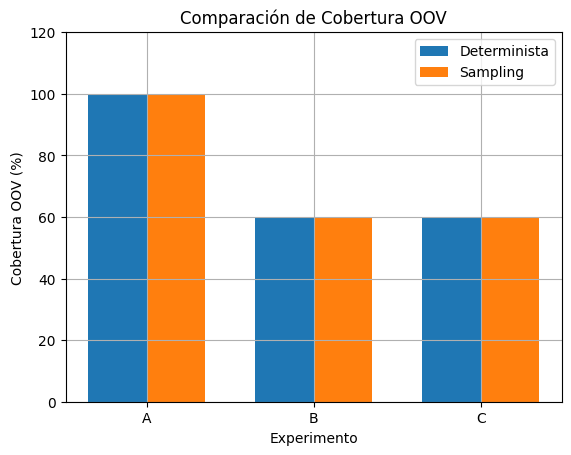

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(resultados, columns=["Experimento", "Oraciones Entrenamiento", "Num Merges", "Cobertura Determinista (%)", "Cobertura Sampling (%)"])
display(df)

# Gráfico
fig, ax = plt.subplots()
index = range(len(df))
bar_width = 0.35

ax.bar(index, df["Cobertura Determinista (%)"], bar_width, label="Determinista")
ax.bar([i + bar_width for i in index], df["Cobertura Sampling (%)"], bar_width, label="Sampling")

ax.set_xlabel("Experimento")
ax.set_ylabel("Cobertura OOV (%)")
ax.set_title("Comparación de Cobertura OOV")
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(df["Experimento"])
ax.legend()
plt.ylim(0, 120)
plt.grid(True)
plt.show()
